https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

In [1]:
#1- Import Libraries
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
#1- Import Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
#2- Define Paths:
label_images_path = 'semantic_drone_dataset/training_set/gt/semantic/label_images/'
label_me_path     = 'semantic_drone_dataset/training_set/gt/semantic/label_me_xml/'
images_path       = 'semantic_drone_dataset/training_set/images/'
class_dict_path   = 'semantic_drone_dataset/training_set/gt/semantic/class_dict.csv'

#label_images_path = '/content/drive/MyDrive/DataScience/Drone_Segmentation/semantic_drone_dataset/training_set/gt/semantic/label_images/'
#label_me_path     = '/content/drive/MyDrive/DataScience/Drone_Segmentation/semantic_drone_dataset/training_set/gt/semantic/label_me_xml/'
#images_path       = '/content/drive/MyDrive/DataScience/Drone_Segmentation/semantic_drone_dataset/training_set/images/'
#class_dict_path   = '/content/drive/MyDrive/DataScience/Drone_Segmentation/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv'

In [5]:
#3- Data Analysis & Split Dataset
images_files = sorted(glob.glob(os.path.join(images_path, "*.jpg")))
label_images = sorted(glob.glob(os.path.join(label_images_path, "*.png")))
assert len(images_files) == len(label_images), "Number of images and masks do not match"
# Remove path and get names
image_names = [x.split('/')[-1].split('.')[0] for x in images_files]         # jpg
label_names = [x.split('/')[-1].split('.')[0] for x in label_images]   # png
assert image_names == label_names, "Names of images and masks do not match"

In [6]:
# Split into training and testing sets
val_size=0.2
test_size=0.1

# Split training set into training and test sets
train_names, test_names = train_test_split(image_names, test_size=test_size, random_state=42)
# Split training set into training and validation sets
train_names, val_names = train_test_split(train_names, test_size=val_size/(1-test_size), random_state=42)

# Print number of samples in each set
print(f'Total Images: {len(images_files)}')
print(f'Total Masks: {len(label_images)}')
print(f'Training samples: {len(train_names)}')
print(f'Validation samples: {len(val_names)}')
print(f'Testing samples: {len(test_names)}')

Total Images: 400
Total Masks: 400
Training samples: 280
Validation samples: 80
Testing samples: 40


In [7]:
class_dict = pd.read_csv(class_dict_path)
class_dict.reset_index(inplace=True)
class_dict.rename(columns={"index": "label"}, inplace=True)
class_dict.drop([0], inplace=True)
class_dict.sample(5)

,label,name,r,g,b
12,12,door,254,148,12
16,16,dog,102,51,0
2,2,dirt,130,76,0
5,5,water,28,42,168
14,14,fence-pole,153,153,153


In [8]:
# Make function to generate 1 channel mask of class values from rgb image.
# Define the RGB values to be replaced with each class
lookupRGB = {
    1: [128, 64, 128],
    2: [130, 76, 0],
    3: [0, 102, 0],
    4: [112, 103, 87],
    5: [28, 42, 168],
    6: [48, 41, 30],
    7: [0, 50, 89],
    8: [107, 142, 35],
    9: [70, 70, 70],
    10: [102, 102, 156],
    11: [254, 228, 12],
    12: [254, 148, 12],
    13: [190, 153, 153],
    14: [153, 153, 153],
    15: [255, 22, 96],
    16: [102, 51, 0],
    17: [9, 143, 150],
    18: [119, 11, 32],
    19: [51, 51, 0],
    20: [190, 250, 190],
    21: [112, 150, 146],
    22: [2, 135, 115],
    23: [255, 0, 0]
}

def rgb2mask(lookupRGB, image):
    # Load PIL image and convert to numpy array
    #image = Image.open("image.jpg")
    image_arr = np.array(image)

    # Initialize the output mask
    mask = np.zeros((image_arr.shape[0], image_arr.shape[1]))

    # Replace the RGB values with class values in the output mask
    for c in lookupRGB:
        mask[np.where(np.all(image_arr == lookupRGB[c], axis=-1))] = c

    # Save the output mask as an PIL image
    mask_img = Image.fromarray(mask.astype('uint8'), mode='L')
    #mask_img.save("output_mask.jpg")
    return mask_img

In [9]:
#4- Define custom Datasets, data augmentation, Data Loaders

class CustomDataset(Dataset):
    def __init__(self, filenames, image_folder, mask_folder, transforms=None):
        self.filenames = filenames
        self.image_folder = image_folder
        self.mask_folder  = mask_folder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.image_folder, filename+'.jpg')
        mask_path = os.path.join(self.mask_folder, filename+'.png')

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')
        
        if self.transforms is not None:
            
            convert_tensor = transforms.ToTensor()
            seed = np.random.randint(2023)
            
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transforms(image)
            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transforms(mask)
            
            # rgb to mask
            mask_img = rgb2mask(lookupRGB, mask) 
            mask_img = np.array(mask_img)
                 
            # convert to tensor
            image_tensor = convert_tensor(image)   # after resize                    
            mask_tensor = torch.from_numpy(mask_img).float()
            
        return image_tensor, mask_tensor, filename

In [10]:
# Define data augmentation

image_size = (224, 224)

transforms_ = transforms.Compose([
    transforms.Resize(image_size),
])

In [11]:
# Create datasets and data loaders
train_dataset = CustomDataset(train_names, images_path, label_images_path, transforms_)
val_dataset = CustomDataset(val_names, images_path, label_images_path, transforms_)
test_dataset = CustomDataset(test_names, images_path, label_images_path, transforms_)

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

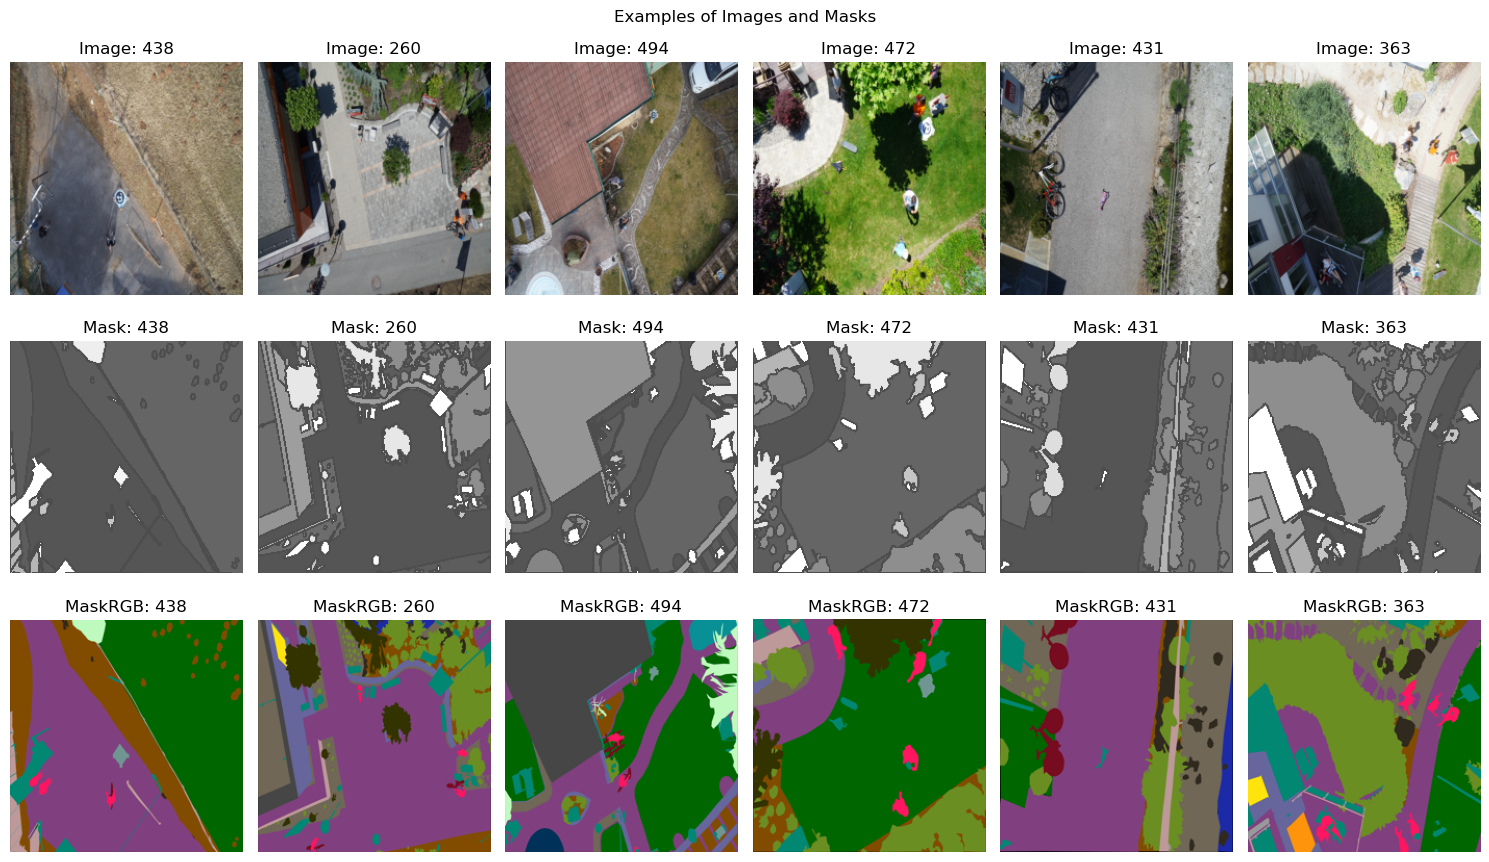

In [12]:
#5- Plot examples of image and mask pairs

images, masks, names = next(iter(train_loader))

def plot_image_mask_pairs(images, masks, names, num_pairs=6):
    fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(15, 9))
    fig.suptitle('Examples of Images and Masks')

    for i in range(num_pairs):
        # Plot image
        axs[0, i].imshow(images[i].permute(1,2,0))
        axs[0, i].set_title('Image: '+str(names[i]))
        axs[0, i].axis('off')    
     
        axs[1, i].imshow(masks[i], alpha=0.7, cmap='gray')
        axs[1, i].set_title('Mask: '+str(names[i]))
        axs[1, i].axis('off')
        # Plot mask RGB
        img_rgb = label_images_path+names[i]+'.png'
        axs[2, i].imshow(Image.open(img_rgb).resize((224,224)))
        axs[2, i].set_title('MaskRGB: '+str(names[i]))
        axs[2, i].axis('off')

    plt.tight_layout()    
    plt.show()

plot_image_mask_pairs(images, masks, names)

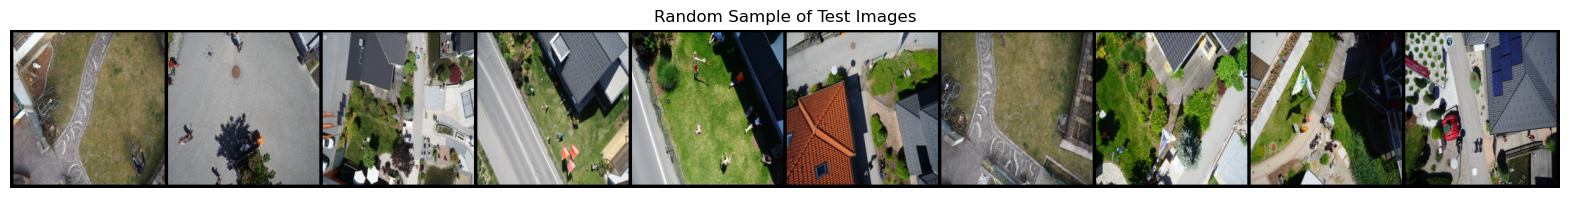

In [13]:
#5b- Plot examples test images
# Set the random seed for reproducibility
#random.seed(42)

# Get the number of images in the test dataset
num_images = len(test_loader.dataset)
# Create a random subset of the test dataset with x images
sample_size = 10
sample_indices = random.sample(range(num_images), sample_size)
sample_subset = data.Subset(test_loader.dataset, sample_indices)
# Create a DataLoader object to load the sample subset
sample_loader = data.DataLoader(sample_subset, batch_size=sample_size, shuffle=False)
# Get a batch of sample images
images, masks, names = next(iter(sample_loader))

# Plot the sample images
fig = plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Random Sample of Test Images")
plt.imshow(vutils.make_grid(images, nrow=10, padding=5, normalize=True).permute(1, 2, 0))
plt.show()

In [14]:
images[0].type(), masks[0].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [15]:
images[0].size(), masks[0].size()

(torch.Size([3, 224, 224]), torch.Size([224, 224]))

In [16]:
#6- Define Model
!pip install git+https://github.com/qubvel/segmentation_models.pytorch --quiet
import segmentation_models_pytorch as smp
import time
num_classes = len(lookupRGB)
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=num_classes, activation=None, 
                 encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = model.to(device)

In [17]:
#7- Define Loss Function, Optimizer, scheduler and Early Stopping class:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [18]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        if self.mode == 'min':
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == 'min':
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        torch.save({'epoch_score': epoch_score, 'model_state_dict': model.state_dict()}, model_path)

In [19]:
def iou_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    union = (outputs | targets).sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou

def pixel_accuracy(outputs, targets):
    correct = (outputs == targets).sum()
    total = targets.numel()
    accuracy = correct / total
    return accuracy

def mean_accuracy(outputs, targets):
    class_accs = []
    for c in range(23):
        class_pixels = (targets == c).sum()
        correct = ((outputs == c) & (targets == c)).sum()
        if class_pixels == 0:
            class_acc = 0
        else:
            class_acc = correct / class_pixels
        class_accs.append(class_acc)
    mean_acc = torch.tensor(class_accs).cpu().numpy().mean()
    return mean_acc

def f1_score(outputs, targets, smooth=1e-6):
    tp = ((outputs == 1) & (targets == 1)).sum()
    fp = ((outputs == 1) & (targets == 0)).sum()
    fn = ((outputs == 0) & (targets == 1)).sum()
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1

def dice_score(outputs, targets, smooth=1e-6):
    intersection = (outputs & targets).sum()
    dice = (2 * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)
    return dice

In [20]:
class TrainerClass:
    def __init__(self, model, train_loader=None, val_loader=None, optimizer=None, criterion=None, scheduler=None, num_epochs=None, early_stopping_patience=None):
        self.num_epochs = num_epochs
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.early_stopping = EarlyStopping(patience=early_stopping_patience)
        
        self.history = {
            'train_loss': [], 
                'train_iou': [], 'train_pixel_acc': [], 'train_mean_acc': [], 'train_f1': [], 'train_dice': [],
            'val_loss': [],
                 'val_iou': [], 'val_pixel_acc': [], 'val_mean_acc': [], 'val_f1': [], 'val_dice': [] }

    def run_one_epoch(self, loader, is_training):
        if is_training:
            self.model.train()
        else:
            self.model.eval()

        epoch_metrics = { 'loss': 0, 'iou': 0, 'pixel_acc': 0, 'mean_acc': 0,  'f1': 0, 'dice': 0 }

        with torch.set_grad_enabled(is_training):
            for inputs, targets, names in tqdm(loader, leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())

                if is_training:
                    # Backward pass and optimization
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                pred_masks = F.softmax(outputs, dim=1)
                pred_masks = torch.argmax(pred_masks, dim=1)
                _, predicted = torch.max(outputs.data, 1)
                pred_masks = pred_masks.long()
                targets = targets.long()

                # Compute the metrics
                epoch_metrics['loss'] += loss.item() * inputs.size(0)
                epoch_metrics['iou'] += iou_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['pixel_acc'] += pixel_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['mean_acc'] += mean_accuracy(pred_masks, targets) * inputs.size(0)
                epoch_metrics['f1'] += f1_score(pred_masks, targets) * inputs.size(0)
                epoch_metrics['dice'] += dice_score(pred_masks, targets) * inputs.size(0)

        epoch_metrics = {k: v / len(loader.dataset) for k, v in epoch_metrics.items()}

        if is_training:
            prefix = 'train'
        else:
            prefix = 'val'

        for k, v in epoch_metrics.items():
            self.history[f'{prefix}_{k}'].append(v)

        return epoch_metrics['loss'], epoch_metrics['iou'], epoch_metrics['pixel_acc'], epoch_metrics['mean_acc'], epoch_metrics['f1'], epoch_metrics['dice']

    def train_and_validate(self):
        for epoch in range(self.num_epochs):

            train_loss, train_iou, train_pixel_acc, train_mean_acc, train_f1, train_dice = self.run_one_epoch(self.train_loader, is_training=True)
            val_loss, val_iou, val_pixel_acc, val_mean_acc, val_f1, val_dice = self.run_one_epoch(self.val_loader, is_training=False)

            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Pixel Acc: {train_pixel_acc:.4f}, Train Mean Acc: {train_mean_acc:.4f}, Train F1: {train_f1:.4f}, Train Dice: {train_dice:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}, Val Mean Acc: {val_mean_acc:.4f}, Val F1: {val_f1:.4f}, Val Dice: {val_dice:.4f}')

            self.early_stopping(val_loss, self.model, 'model_checkpoint.pth')

            if self.scheduler:
                self.scheduler.step(val_loss)

            if self.early_stopping.early_stop:
                print('Early stopping')
                break

        return self.history

In [21]:
trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=25, early_stopping_patience=10)
history = trainer.train_and_validate()

Epoch 1/25
Train Loss: 2.2266, Train IoU: 0.2504, Train Pixel Acc: 0.4513, Train Mean Acc: 0.1076, Train F1: 0.8380, Train Dice: 0.3964
Val Loss: 2.8375, Val IoU: 0.2293, Val Pixel Acc: 0.4744, Val Mean Acc: 0.0842, Val F1: 0.8771, Val Dice: 0.3713


Epoch 2/25
Train Loss: 1.5075, Train IoU: 0.3115, Train Pixel Acc: 0.5845, Train Mean Acc: 0.1392, Train F1: 0.9016, Train Dice: 0.4724
Val Loss: 1.4929, Val IoU: 0.2790, Val Pixel Acc: 0.5646, Val Mean Acc: 0.1399, Val F1: 0.9130, Val Dice: 0.4345


Epoch 3/25
Train Loss: 1.2511, Train IoU: 0.3525, Train Pixel Acc: 0.6355, Train Mean Acc: 0.1641, Train F1: 0.9143, Train Dice: 0.5181
Val Loss: 1.3583, Val IoU: 0.3086, Val Pixel Acc: 0.6007, Val Mean Acc: 0.1471, Val F1: 0.9209, Val Dice: 0.4696


Epoch 4/25
Train Loss: 1.2137, Train IoU: 0.3716, Train Pixel Acc: 0.6427, Train Mean Acc: 0.1769, Train F1: 0.9194, Train Dice: 0.5393
Val Loss: 1.1209, Val IoU: 0.3617, Val Pixel Acc: 0.6687, Val Mean Acc: 0.1870, Val F1: 0.9303, Val Dice: 0.5296


Epoch 5/25
Train Loss: 1.1273, Train IoU: 0.3980, Train Pixel Acc: 0.6661, Train Mean Acc: 0.1891, Train F1: 0.9251, Train Dice: 0.5671
Val Loss: 1.3476, Val IoU: 0.3248, Val Pixel Acc: 0.5921, Val Mean Acc: 0.1900, Val F1: 0.9050, Val Dice: 0.4885


Epoch 6/25
Train Loss: 1.0956, Train IoU: 0.3892, Train Pixel Acc: 0.6659, Train Mean Acc: 0.1942, Train F1: 0.9290, Train Dice: 0.5580
Val Loss: 1.0425, Val IoU: 0.3691, Val Pixel Acc: 0.6769, Val Mean Acc: 0.2010, Val F1: 0.9319, Val Dice: 0.5376


Epoch 7/25
Train Loss: 1.0845, Train IoU: 0.3977, Train Pixel Acc: 0.6661, Train Mean Acc: 0.2016, Train F1: 0.9306, Train Dice: 0.5661
Val Loss: 1.1025, Val IoU: 0.3841, Val Pixel Acc: 0.6657, Val Mean Acc: 0.2122, Val F1: 0.9410, Val Dice: 0.5528


Epoch 8/25
Train Loss: 1.0175, Train IoU: 0.4216, Train Pixel Acc: 0.6859, Train Mean Acc: 0.2165, Train F1: 0.9316, Train Dice: 0.5915
Val Loss: 1.0481, Val IoU: 0.3782, Val Pixel Acc: 0.6831, Val Mean Acc: 0.2030, Val F1: 0.9375, Val Dice: 0.5472


Epoch 9/25
Train Loss: 0.9558, Train IoU: 0.4326, Train Pixel Acc: 0.7017, Train Mean Acc: 0.2368, Train F1: 0.9341, Train Dice: 0.6027
Val Loss: 0.8844, Val IoU: 0.4547, Val Pixel Acc: 0.7309, Val Mean Acc: 0.2663, Val F1: 0.9451, Val Dice: 0.6242


Epoch 10/25
Train Loss: 0.8692, Train IoU: 0.4742, Train Pixel Acc: 0.7294, Train Mean Acc: 0.2674, Train F1: 0.9417, Train Dice: 0.6416
Val Loss: 0.8674, Val IoU: 0.4575, Val Pixel Acc: 0.7261, Val Mean Acc: 0.2738, Val F1: 0.9482, Val Dice: 0.6265


Epoch 11/25
Train Loss: 0.8985, Train IoU: 0.4718, Train Pixel Acc: 0.7227, Train Mean Acc: 0.2705, Train F1: 0.9396, Train Dice: 0.6390
Val Loss: 0.9257, Val IoU: 0.4356, Val Pixel Acc: 0.7109, Val Mean Acc: 0.2796, Val F1: 0.9401, Val Dice: 0.6056


Epoch 12/25
Train Loss: 0.8968, Train IoU: 0.4765, Train Pixel Acc: 0.7221, Train Mean Acc: 0.2713, Train F1: 0.9409, Train Dice: 0.6441
Val Loss: 0.8605, Val IoU: 0.4602, Val Pixel Acc: 0.7316, Val Mean Acc: 0.2766, Val F1: 0.9501, Val Dice: 0.6291


Epoch 13/25
Train Loss: 0.8613, Train IoU: 0.4846, Train Pixel Acc: 0.7315, Train Mean Acc: 0.2785, Train F1: 0.9431, Train Dice: 0.6506
Val Loss: 0.8539, Val IoU: 0.4622, Val Pixel Acc: 0.7358, Val Mean Acc: 0.2901, Val F1: 0.9475, Val Dice: 0.6304


Epoch 14/25
Train Loss: 0.7966, Train IoU: 0.5050, Train Pixel Acc: 0.7489, Train Mean Acc: 0.2970, Train F1: 0.9455, Train Dice: 0.6698
Val Loss: 0.7934, Val IoU: 0.4743, Val Pixel Acc: 0.7446, Val Mean Acc: 0.2948, Val F1: 0.9514, Val Dice: 0.6417


Epoch 15/25
Train Loss: 0.7877, Train IoU: 0.5182, Train Pixel Acc: 0.7508, Train Mean Acc: 0.3083, Train F1: 0.9459, Train Dice: 0.6815
Val Loss: 0.7916, Val IoU: 0.4888, Val Pixel Acc: 0.7476, Val Mean Acc: 0.3076, Val F1: 0.9512, Val Dice: 0.6547


Epoch 16/25
Train Loss: 0.7866, Train IoU: 0.5181, Train Pixel Acc: 0.7520, Train Mean Acc: 0.3116, Train F1: 0.9445, Train Dice: 0.6816
Val Loss: 0.8157, Val IoU: 0.4918, Val Pixel Acc: 0.7425, Val Mean Acc: 0.3261, Val F1: 0.9526, Val Dice: 0.6581


Epoch 17/25
Train Loss: 0.7651, Train IoU: 0.5170, Train Pixel Acc: 0.7546, Train Mean Acc: 0.3175, Train F1: 0.9454, Train Dice: 0.6805
Val Loss: 0.7866, Val IoU: 0.4923, Val Pixel Acc: 0.7518, Val Mean Acc: 0.3017, Val F1: 0.9510, Val Dice: 0.6578


Epoch 18/25
Train Loss: 0.7517, Train IoU: 0.5339, Train Pixel Acc: 0.7628, Train Mean Acc: 0.3263, Train F1: 0.9483, Train Dice: 0.6944
Val Loss: 0.7773, Val IoU: 0.5078, Val Pixel Acc: 0.7534, Val Mean Acc: 0.3342, Val F1: 0.9580, Val Dice: 0.6716


Epoch 19/25
Train Loss: 0.7185, Train IoU: 0.5415, Train Pixel Acc: 0.7692, Train Mean Acc: 0.3332, Train F1: 0.9492, Train Dice: 0.7013
Val Loss: 0.7135, Val IoU: 0.5327, Val Pixel Acc: 0.7740, Val Mean Acc: 0.3432, Val F1: 0.9567, Val Dice: 0.6940


Epoch 20/25
Train Loss: 0.6757, Train IoU: 0.5661, Train Pixel Acc: 0.7815, Train Mean Acc: 0.3474, Train F1: 0.9494, Train Dice: 0.7219
Val Loss: 0.7050, Val IoU: 0.5444, Val Pixel Acc: 0.7767, Val Mean Acc: 0.3520, Val F1: 0.9554, Val Dice: 0.7040


Epoch 21/25
Train Loss: 0.6965, Train IoU: 0.5752, Train Pixel Acc: 0.7758, Train Mean Acc: 0.3568, Train F1: 0.9491, Train Dice: 0.7290
Val Loss: 0.7398, Val IoU: 0.5361, Val Pixel Acc: 0.7731, Val Mean Acc: 0.3690, Val F1: 0.9560, Val Dice: 0.6970


Epoch 22/25
Train Loss: 0.6606, Train IoU: 0.5774, Train Pixel Acc: 0.7861, Train Mean Acc: 0.3548, Train F1: 0.9523, Train Dice: 0.7312
Val Loss: 0.7142, Val IoU: 0.5303, Val Pixel Acc: 0.7737, Val Mean Acc: 0.3585, Val F1: 0.9561, Val Dice: 0.6921


Epoch 23/25
Train Loss: 0.6514, Train IoU: 0.5773, Train Pixel Acc: 0.7875, Train Mean Acc: 0.3719, Train F1: 0.9538, Train Dice: 0.7303
Val Loss: 0.7861, Val IoU: 0.5086, Val Pixel Acc: 0.7596, Val Mean Acc: 0.3424, Val F1: 0.9565, Val Dice: 0.6730


Epoch 24/25
Train Loss: 0.6838, Train IoU: 0.5605, Train Pixel Acc: 0.7783, Train Mean Acc: 0.3581, Train F1: 0.9526, Train Dice: 0.7159
Val Loss: 0.7196, Val IoU: 0.5387, Val Pixel Acc: 0.7744, Val Mean Acc: 0.3463, Val F1: 0.9556, Val Dice: 0.6993


Epoch 25/25
Train Loss: 0.6632, Train IoU: 0.5789, Train Pixel Acc: 0.7844, Train Mean Acc: 0.3711, Train F1: 0.9542, Train Dice: 0.7318
Val Loss: 0.6806, Val IoU: 0.5583, Val Pixel Acc: 0.7829, Val Mean Acc: 0.3766, Val F1: 0.9574, Val Dice: 0.7156


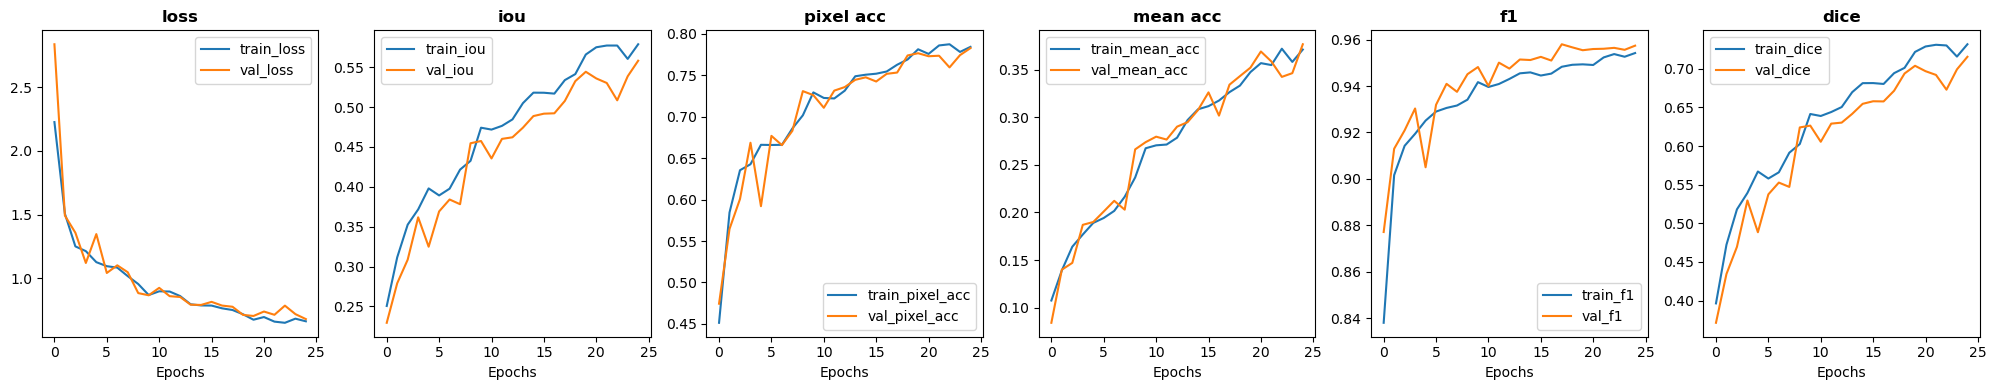

In [22]:
def plot_history(history):

    fig, axs = plt.subplots(1, 6, figsize=(20, 4))

    for i, (key, values) in enumerate(history.items()):
        col = i % 6
        axs[col].plot(values, label=key)
        axs[col].set_title(' '.join(key.split('_')[1:]), fontweight ='bold')
        axs[col].set_xlabel("Epochs")
        axs[col].legend()

    plt.tight_layout()
    plt.show()
    
plot_history(history)

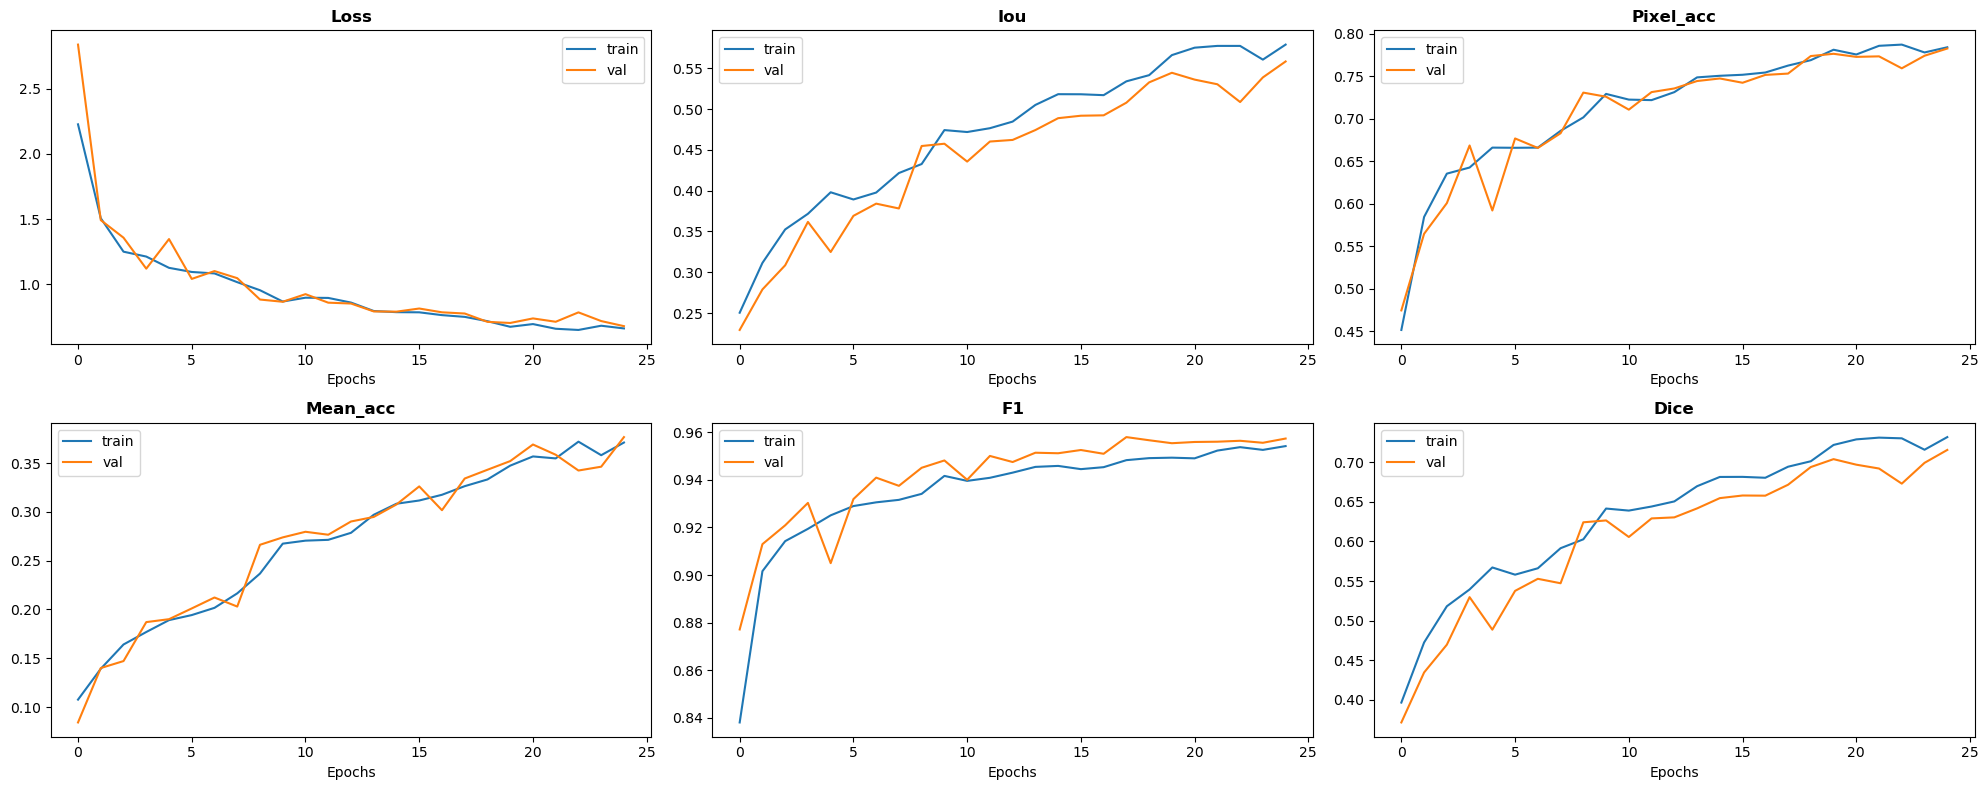

In [23]:
def plot_history(history):
    fig, axs = plt.subplots(2, 3, figsize=(20, 8)) 

    metrics = ['loss', 'iou', 'pixel_acc', 'mean_acc', 'f1', 'dice']
    for i, metric in enumerate(metrics):    
        row = i // 3
        col = i % 3 

        axs[row, col].plot(history[f'train_{metric}'], label='train')
        axs[row, col].plot(history[f'val_{metric}'], label='val')
        axs[row, col].set_title(metric.capitalize(), fontweight ='bold')
        axs[row, col].set_xlabel("Epochs")
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [24]:
#11- Evaluate model on the test set
# Load the saved model
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

#trainer = TrainerClass(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=3, early_stopping_patience=5)

# Set the model to evaluation mode
model.eval()

# Test on the test_loader
test_loss, test_iou, test_pixel_acc, test_mean_acc, test_f1, test_dice = trainer.run_one_epoch(test_loader, is_training=False)
print(f'Test Loss: {test_loss:.4f}') 
print(f'Test IoU: {test_iou:.4f}') 
print(f'Test Pixel Acc: {test_pixel_acc:.4f}') 
print(f'Test Mean Acc: {test_mean_acc:.4f}') 
print(f'Test F1: {test_f1:.4f}')
print(f'Test Dice: {test_dice:.4f}')     

Test Loss: 0.6842
Test IoU: 0.5476
Test Pixel Acc: 0.7826
Test Mean Acc: 0.3252
Test F1: 0.9496
Test Dice: 0.7067


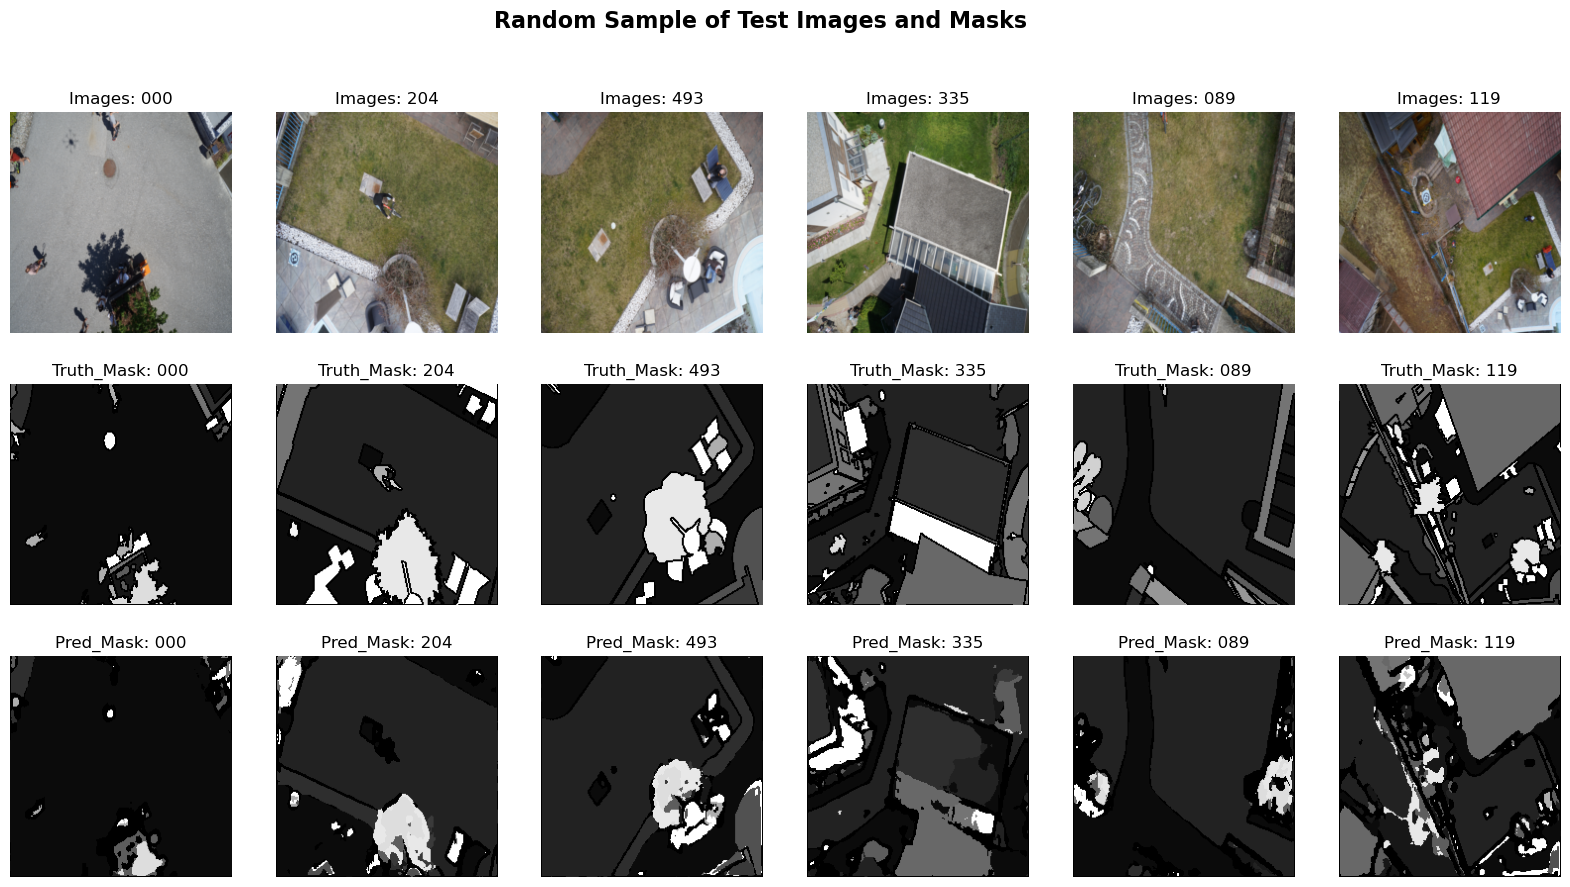

In [38]:
#12- Plot model evaluated on the test set
# Set the random seed for reproducibility
#random.seed(42)
# Load the saved model
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()

# Get a batch of sample images and masks
sample_size = 6
sample_indices = random.sample(range(len(test_loader.dataset)), sample_size)
sample_subset = data.Subset(test_loader.dataset, sample_indices)
sample_loader = data.DataLoader(sample_subset, batch_size=sample_size, shuffle=False)

# Perform inference on any image
image = Image.open('image.jpg')
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    # Get a batch of images and masks from the dataloader
    images, masks, names = next(iter(sample_loader))
    images = images.to(device)
    masks = masks.to(device)
    output = model(images)
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze().cpu().numpy()

    # Create a grid of subplots to plot the sample images and masks
    fig, axs = plt.subplots(3, sample_size, figsize=(20, 10))

    # Plot each image and mask in a separate subplot
    for i in range(sample_size):
        # Plot the image
        axs[0, i].imshow(images[i].permute(1, 2, 0))
        axs[0, i].set_title('Images: '+str(names[i]))
        axs[0, i].axis("off")

        # Plot the ground truth mask
        axs[1, i].imshow(masks[i], cmap='gray')
        axs[1, i].set_title('Truth_Mask: '+str(names[i]))
        axs[1, i].axis("off")

        # Plot the predicted mask (assuming it's stored in a variable called mask_predicted)
        mask_predicted = model(images.to(device))
        axs[2, i].imshow(pred_mask[i], cmap='gray')
        axs[2, i].set_title('Pred_Mask: '+str(names[i]))
        axs[2, i].axis("off")

    # Set the title of the plot
    fig.suptitle("Random Sample of Test Images and Masks", fontsize=16, fontweight='bold')

    # Show the plot
    plt.show()

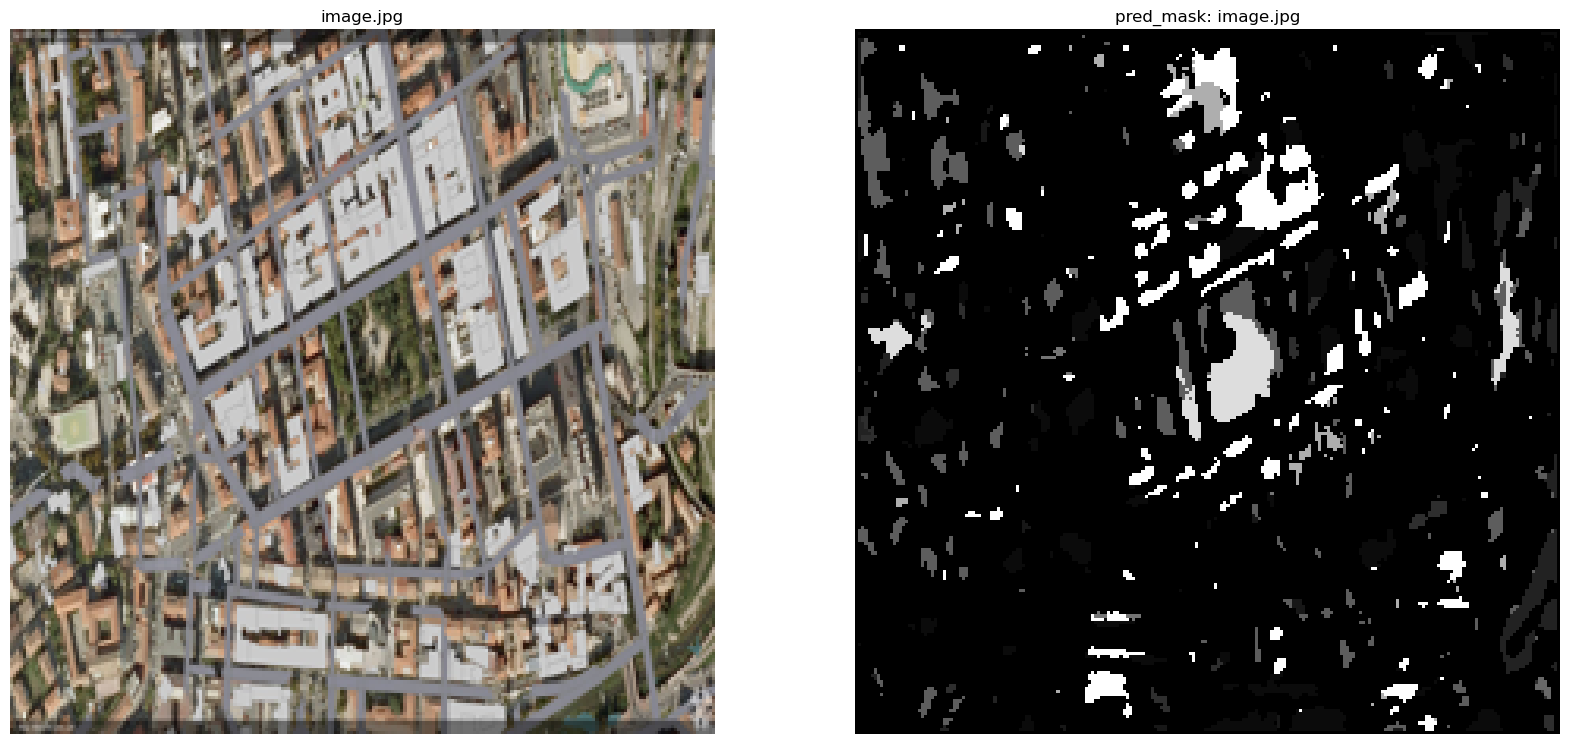

In [37]:
# 13- Use the saved model for inference on new images,

image_inference = 'image.jpg'

# Load the saved model
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# Set the model to evaluation mode
model.eval()
# Perform inference on any image
image = Image.open(image_inference).resize((224,224))
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor.to(device))
    pred_mask = F.softmax(output, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.squeeze().cpu().numpy()
    
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[0].set_title(image_inference)
axs[0].axis("off")

# Plot the pred mask
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('pred_mask: '+image_inference)
axs[1].axis("off")
plt.show()